# Bounding-Box Regression: License Plate Detection

## Prepping the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [ ]:
def resize_annotations(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    adj_width = int(root.find('size')[0].text)/IMG_SIZE
    adj_height = int(root.find('size')[1].text)/IMG_SIZE
    
    for boxes in root.iter('object'):
    
        filename = root.find('filename').text
        
        ymin = int(boxes.find("bndbox/ymin").text)/adj_height
        xmin = int(boxes.find("bndbox/xmin").text)/adj_width
        ymax = int(boxes.find("bndbox/ymax").text)/adj_height
        xmax = int(boxes.find("bndbox/xmax").text)/adj_width
    
        coords = [int(xmax), int(ymax), int(xmin), int(ymin)]

    return filename, coords


In [ ]:
IMG_SIZE = 224
X = []
y = []

root_dir = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "Object Detection Tutorial")

img_dir = os.path.join(root_dir, "CLP-Detection", "data", "images")
annot_dir = os.path.join(root_dir, "CLP-Detection", "data", "annotations")

img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
annot_paths = sorted([os.path.join(annot_dir, f) for f in os.listdir(annot_dir)])

In [ ]:
for p in tqdm(img_paths):
    img = cv2.imread(p)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(np.array(img))

100%|██████████| 433/433 [00:05<00:00, 73.96it/s]


In [ ]:
for p in tqdm(annot_paths):
    name, boxes = resize_annotations(p)
    y.append(boxes)

100%|██████████| 433/433 [00:00<00:00, 1149.92it/s]


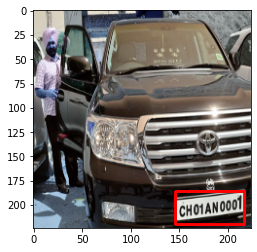

In [ ]:
image = cv2.rectangle(X[100], (y[100][0], y[100][1]), (y[100][2], y[100][3]), color=(255, 0, 0), thickness=2)

plt.imshow(image)
plt.show()

In [ ]:
# Transform to array

X = np.array(X)
y = np.array(y)

In [ ]:
# Renormalisation
X = X / 255
y = y / 255

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Bounding Box Regression

- For object *localization*, we need to predict the *bounding box* of the object(s) in the image.
- This is not a discrete prediction task - finding the probabilities for a bounding box to appear *anywhere* in an image just doesn't make sense.
- Need to perform a regession on the image with known values for the bounding box. 
 - a model will output 4 values as a prediction - the values correspond to the ($x_1$, $y_1$) and ($x_2$,$y_2$) coordinates of the object's bounding box(es). These two points represent the top-left and bottom-right corners of the bounding box.
 - minimize the *loss* of these outputted coordinates using $L2$ loss.
- Because this is not a classification task, our regression network will only contain a single output layer consisting of 4 output nodes (one for each coordinate along the X or Y axis). 
 - This output layer will use sigmoid activation function


In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load a pre-trained model, 'chop off' the model head (i.e. the Fully-Connected layers)
pretrained = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

# We're not fine-tuning anything, so turn of training for all layers
pretrained.trainable = False

# Flatten the 3-dimensional outputs of the pre-trained layers
x = Flatten()(pretrained.output)

# Define a new model head for predicting bbox coordinates
reg_head = Dense(128, activation="relu")(x)
reg_head = Dense(64, activation="relu")(reg_head)
reg_head = Dropout(0.3)(reg_head)

reg_head = Dense(4, activation="sigmoid")(reg_head)

model = Model(inputs=pretrained.input, outputs=reg_head)
#print(model.summary())

In [ ]:
# Define a optimizer and compile the model
optim = Adam(lr=0.00001)

monitor = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model.compile(loss="mean_squared_error", optimizer=optim, metrics=['mean_absolute_error'])

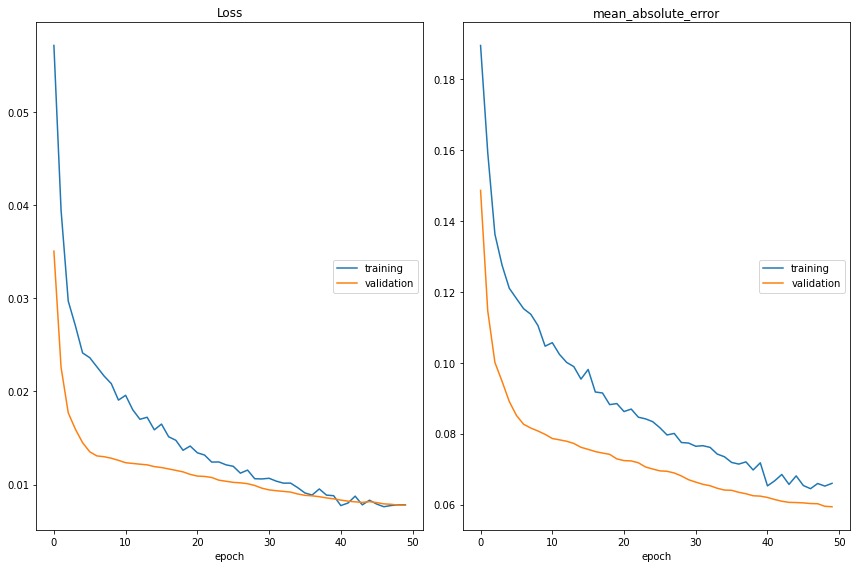

Loss
	training         	 (min:    0.008, max:    0.057, cur:    0.008)
	validation       	 (min:    0.008, max:    0.035, cur:    0.008)
mean_absolute_error
	training         	 (min:    0.064, max:    0.190, cur:    0.066)
	validation       	 (min:    0.059, max:    0.149, cur:    0.059)


In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64, epochs=50,
                    callbacks=[monitor, PlotLossesKeras()],
                    verbose=1)

In [ ]:
# TODO: evaluate the model
y_preds = model.predict(X_test)

In [ ]:
# R2 Score: the coefficient of determination
r2 = r2_score(y_test, y_preds)

# Mean Absolute Error: mean of the absolute errors (magnitude is not considered)
mae = mean_absolute_error(y_test, y_preds)

# Mean Square Error: mean of the summed squared errors
mse = mean_squared_error(y_test, y_preds)

# RMSE: square root of the MSE ensuring that reported error is interpretable in the context of the training data (same units)
rmse = np.sqrt(mse)

In [ ]:
print("R2 Score: {:.4f}".format(r2))

print("\nMean Absolute Error: {:.4f}".format(mae))

print("\nMean Squared Error: {:.4f}".format(mse))

print("\nRoot Mean Squared Error: {:.4f}".format(rmse))

R2 Score: 0.5573

Mean Absolute Error: 0.0616

Mean Squared Error: 0.0076

Root Mean Squared Error: 0.0873


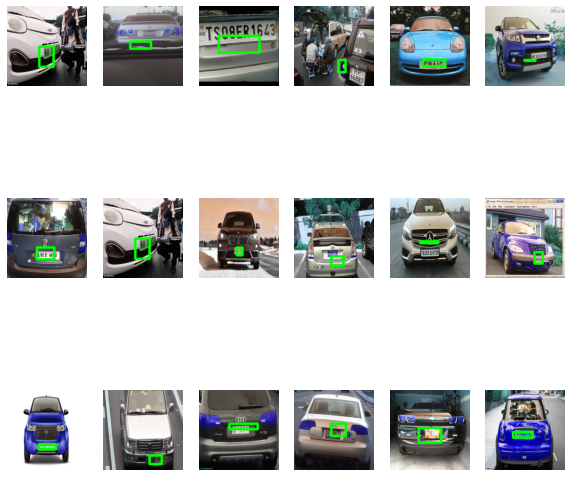

In [ ]:
plt.figure(figsize=(10,10))

for i in range(0, 18):

    plt.subplot(3, 6, i+1)
    plt.axis('off')
    
    coords = y_preds[i]*255
    image = cv2.rectangle(X_test[i], (int(coords[0]), int(coords[1])), (int(coords[2]), int(coords[3])), (0, 1, 0), 5)
    plt.imshow((image*255).astype('uint8'))
    
plt.savefig(os.path.join(root_dir, "preds_1.png"))

In [ ]:
model.save(os.path.join(root_dir, 'model_1.h5'))